# 03/14/24 - Trying to see if I can make sense of this PSJ0147 spectrum from KCRM.

In [1]:
# import general libraries and modules
import numpy as np
np.set_printoptions(threshold=10000)
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import patches
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams.update({'font.size': 14})
import pandas as pd
import warnings
warnings.filterwarnings( "ignore", module = "matplotlib\..*" )
warnings.filterwarnings( "ignore", module = "plotbin\..*" )
import io
from os import path
import glob
#import Image from PIL
from PIL import Image
import dill as pickle

# my functions
import sys
sys.path.append("/home/shawnknabel/Documents/slacs_kinematics/my_python_packages")
# slacs_kcwi_kineamtics
from slacs_kcwi_kinematics import slacs_kcwi_kinematics

################################################################
# some needed information
kcwi_scale = 0.1457  # arcsec/pixel
hst_scale = 0.050 # ACS/WFC

c = 299792.458 # km/s


In [2]:
# specify object directory and name

#################################################
# date and number of initial kinematics run e.g. 2023-02-28_2
date_of_kin = '2024_02_15'
date_of_mge = '2023-02-28_2' # The MGEs I did for these kinematics will still be good. don't need to redo them
###################################################################################################################################

#------------------------------------------------------------------------------
# Directories and files

# data directory
data_dir = '/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/'
hst_dir = '/data/raw_data/HST_SLACS_ACS/kcwi_kinematics_lenses/'
tables_dir = f'{data_dir}tables/'
# get the revised KCWI sigmapsf
sigmapsf_table = pd.read_csv(f'{tables_dir}kcwi_sigmapsf_estimates.csv')
mosaics_dir = f'{data_dir}mosaics/'
kinematics_full_dir = f'{data_dir}kinematics/'
kinematics_dir =f'{kinematics_full_dir}{date_of_kin}/'
mge_dir = f'{kinematics_full_dir}{date_of_mge}/'
print(f'Outputs will be in {kinematics_dir}')
print()

# target SN for voronoi binning
#vorbin_SN_targets = np.array([10, 15, 20])
vorbin_SN_targets = np.array([15])
sps_name = 'xshooter'

#################################################
# objects
obj_names = ['SDSSJ0029-0055',
             'SDSSJ0037-0942',
             'SDSSJ0330-0020',
             'SDSSJ1112+0826',
             'SDSSJ1204+0358',
             'SDSSJ1250+0523',
             'SDSSJ1306+0600',
             'SDSSJ1402+6321',
             'SDSSJ1531-0105',
             'SDSSJ1538+5817',
             'SDSSJ1621+3931',
             'SDSSJ1627-0053',
             'SDSSJ1630+4520',
             'SDSSJ2303+1422'
            ]

#################################################


paper_table = pd.read_csv(f'{tables_dir}paper_table_022224.csv')

Outputs will be in /data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/kinematics/2024_02_15/



In [3]:
from astropy.io import fits

In [4]:
spectrum = fits.getdata('/data/raw_data/Keck_KCWI_drizzle/PSJ0147+4630/KCWI_PSJ0147_extracted_spectrum.fits')
header = fits.getheader('/data/raw_data/Keck_KCWI_drizzle/PSJ0147+4630/KCWI_PSJ0147_extracted_spectrum.fits')

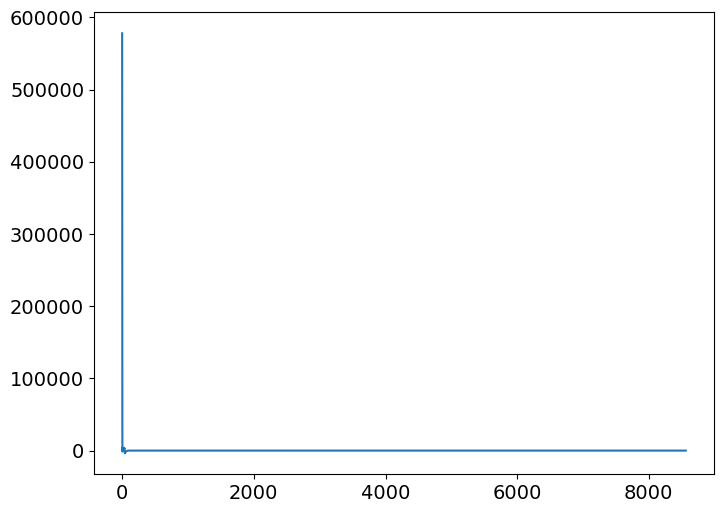

In [5]:
plt.plot(spectrum)

In [6]:
# Universal parameters
# todays date
date = '03142024'#datetime.now().strftime("%Y_%m_%d")

#if not os.path.exists(kinematics_dir):
#    os.mkdir(kinematics_dir)
#------------------------------------------------------------------------------
# Kinematics systematics initial choices
# aperture
aperture = 'R2'
# wavelength range
wave_min = 3750
wave_max = 4100 ########### NOTE J0330 will be different
# degree of the additive Legendre polynomial in ppxf
degree = 4 # 900/250 = 3.6 round up
#------------------------------------------------------------------------------
# Information specific to KCWI and templates
kcwi_scale = 0.1457
## R=3600. spectral resolution is ~ 1.42A
FWHM_data = 1.42 #1.42
## initial estimate of the noise
noise = 0.014
# velocity scale ratio
velscale_ratio = 2
# FWHM of templates
FWHM_xshooter = 0.403 # Angstroms
FWHM_emiles = 2.51 # Angstroms
# central wavelength is where we measure FWHM
central_wavelength = 3950
#------------------------------------------------------------------------------
# variable settings in ppxf and utility functions
# cut the datacube at lens center, radius given here
radius_in_pixels = 21
# target SN for voronoi binning
#vorbin_SN_targets = np.array([10, 15, 20])
bin_target_SN = 15.
# minimum SN of pixels to be included in voronoi bining
pixel_min_SN = 1.
# stellar population
sps_names = ['xshooter','emiles']
sps_name = sps_names[1]

In [7]:
# Set 'obj_name', 'z', 'T_exp'
obj_name = 'PSJ0147+4630'
obj_abbr = 'PSJ0147'#obj_name[4:9] # e.g. J0029
zlens = 0.678 # lens redshift
T_exp = 1800*5 # exposure time in seconds... this is where I made the disastrous mistake
lens_center_x,lens_center_y = 60, 134
# other necessary directories ... Be very careful! This is how we will make sure we are using the correct files moving forward.
mos_dir = '/data/raw_data/Keck_KCWI_drizzle/PSJ0147+4630/'#f'{data_dir}mosaics/{obj_name}/' # files should be loaded from here but not saved
kin_dir = '/data/raw_data/Keck_KCWI_drizzle/PSJ0147+4630/'#f'{data_dir}kinematics/{obj_name}/'

mos_name = f'KCWI_{obj_abbr}_icubes_mosaic_0.1457'
kcwi_datacube = f'{mos_dir}{mos_name}.fits'
#spectrum from the lens center # using R=2
central_spectrum_file = '/data/raw_data/Keck_KCWI_drizzle/PSJ0147+4630/KCWI_PSJ0147_extracted_spectrum.fits'
background_spectrum_file = '/data/raw_data/Keck_KCWI_drizzle/PSJ0147+4630/sky_spectrum.fits'
background_source_mask_file = '/data/raw_data/Keck_KCWI_drizzle/PSJ0147+4630/mask.reg'


In [16]:
psj0147_kinematics = slacs_kcwi_kinematics(
                                         mos_dir=mos_dir,
                                         kin_dir=kin_dir,
                                         obj_name=obj_name,
                                         kcwi_datacube_file=kcwi_datacube,
                                         central_spectrum_file=central_spectrum_file,
                                         background_spectrum_file=background_spectrum_file,
                                         background_source_mask_file=background_source_mask_file,
                                         zlens=zlens,
                                         exp_time=T_exp,
                                         lens_center_x=lens_center_x,
                                         lens_center_y=lens_center_y,
                                         aperture=aperture,
                                         wave_min=wave_min,
                                         wave_max=wave_max,
                                         degree=degree,
                                         sps_name=sps_name,
                                         FWHM_templates=FWHM_emiles,
                                         FWHM_data=FWHM_data,
                                         pixel_scale=kcwi_scale,
                                         noise=noise,
                                         central_wavelength=central_wavelength,
                                         velscale_ratio=velscale_ratio,
                                         radius_in_pixels=radius_in_pixels,
                                         bin_target_SN=bin_target_SN,
                                         pixel_min_SN=pixel_min_SN,
                                         plot=True,
                                         quiet=False
)

pPXF will now consume your soul and use it to measure the kinematics of PSJ0147+4630.


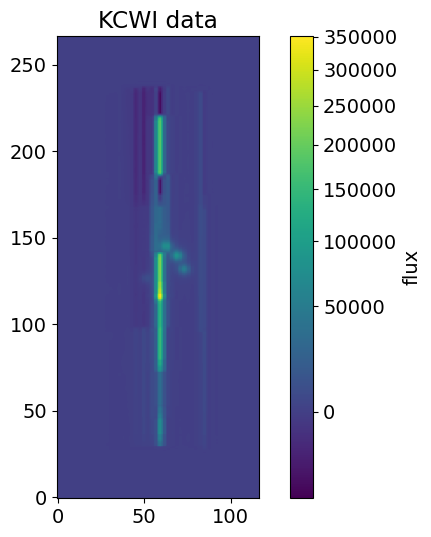

Resolution of templates is larger than data, correction will be added quadratically to all measured velocity dispersions.
Templates do not cover galaxy upper wavelength range. Adding zeros.
Check this fit to be sure the 0s are not in the fit range.
 Best Fit:       Vel     sigma
 comp.  0:        87       216
chi2/DOF: 5834.; DOF: 1352; degree = 4; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 14; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 11/629


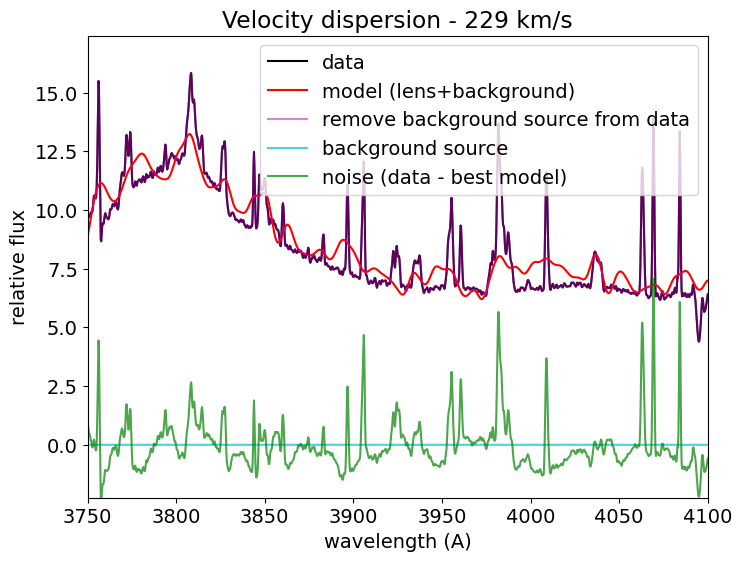

Formal errors:
     dV    dsigma   dh3      dh4
      17      18
Elapsed time in pPXF: 2.61 s


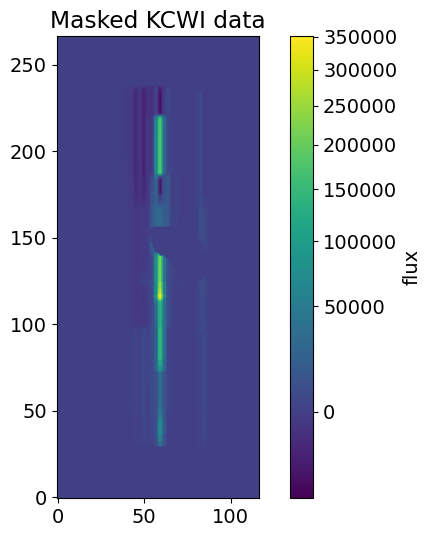

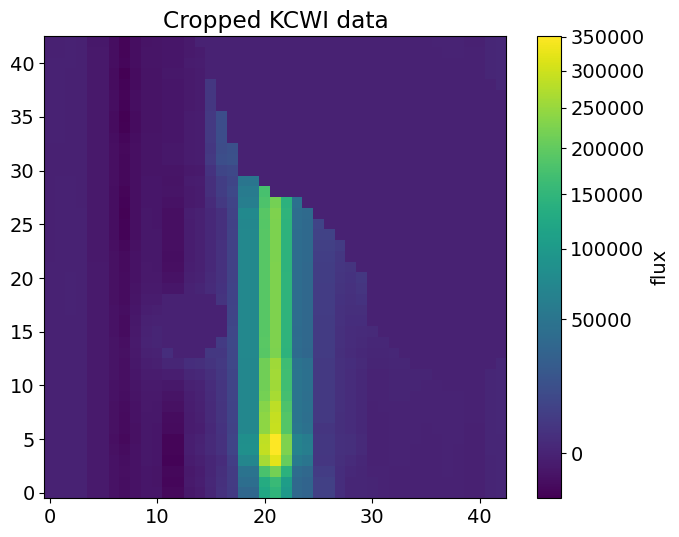

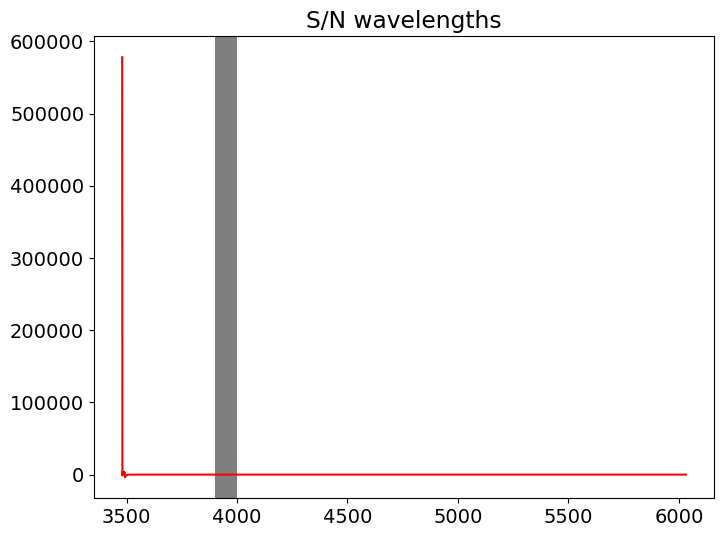

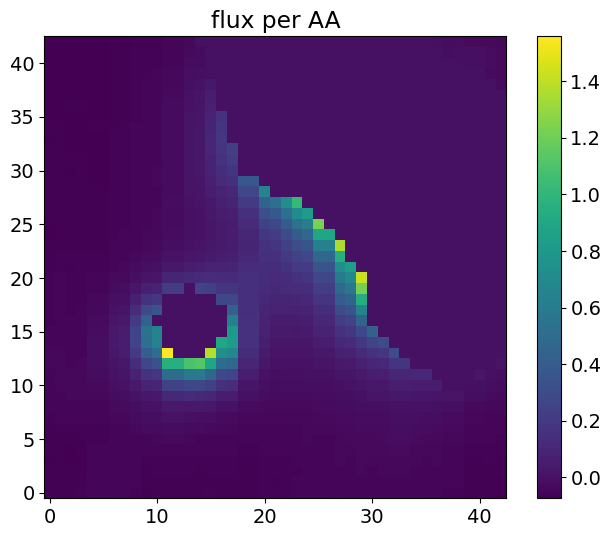

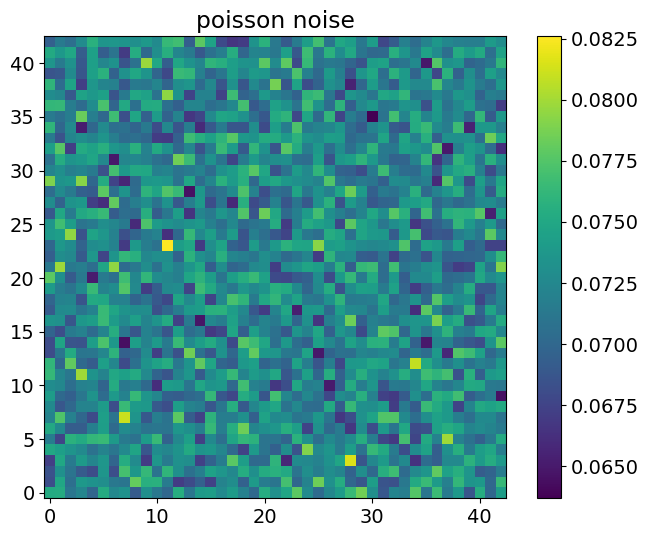

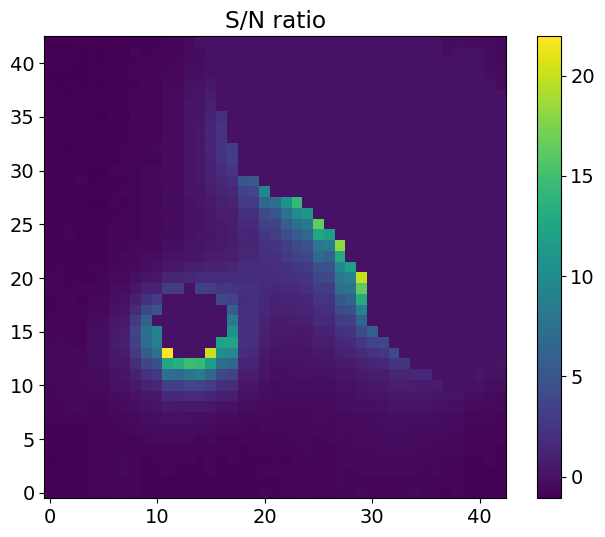

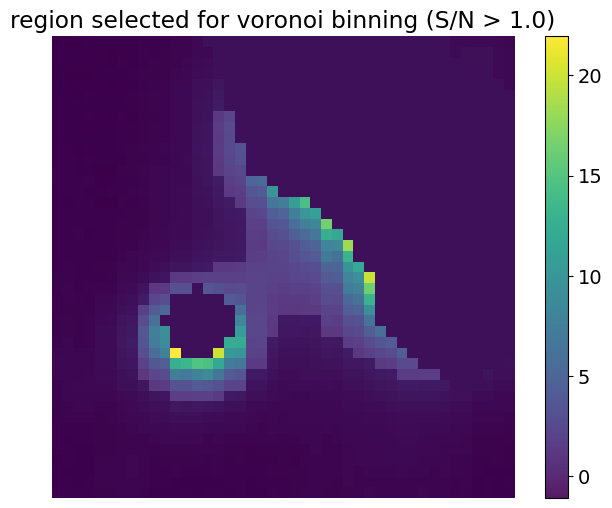

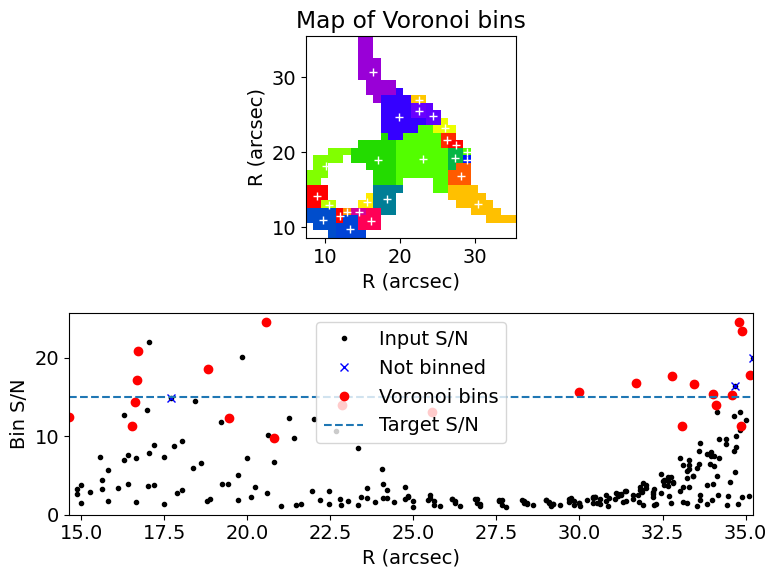

Number of bins = 26


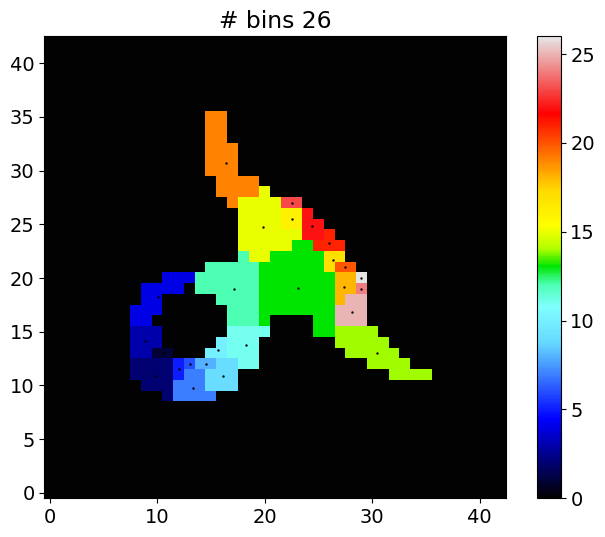

/home/shawnknabel/.local/lib/python3.11/site-packages/ppxf/capfit.py:922: RuntimeWarning: invalid value encountered in scalar divide
  ratio = actred/prered


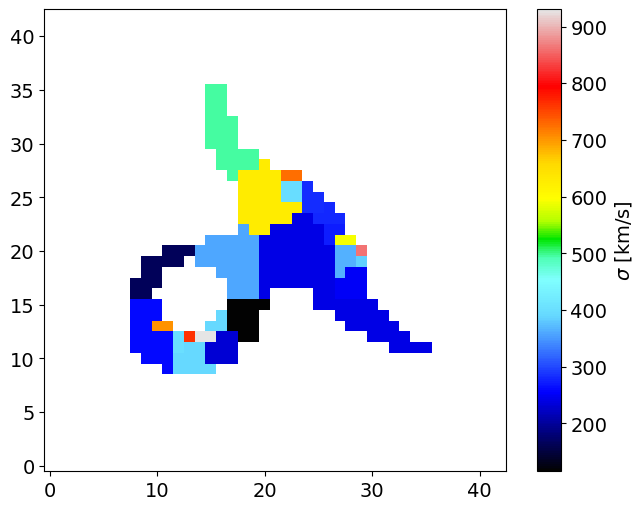

<Figure size 800x600 with 0 Axes>

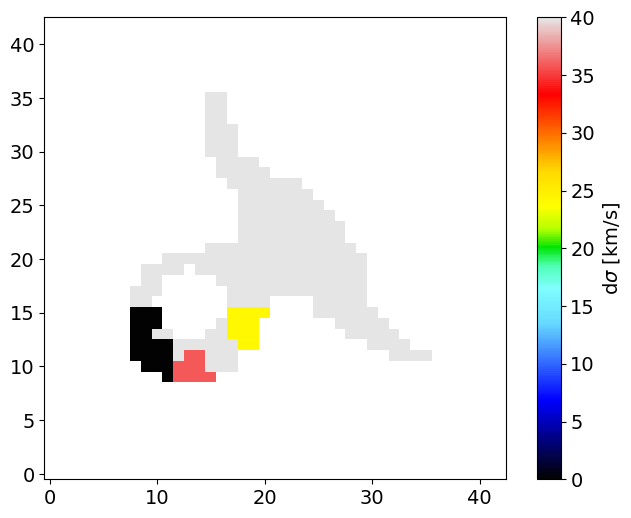

<Figure size 800x600 with 0 Axes>

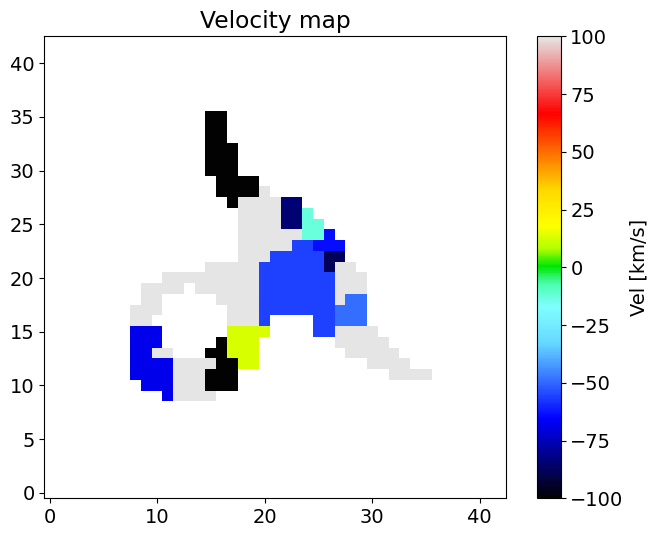

<Figure size 800x600 with 0 Axes>

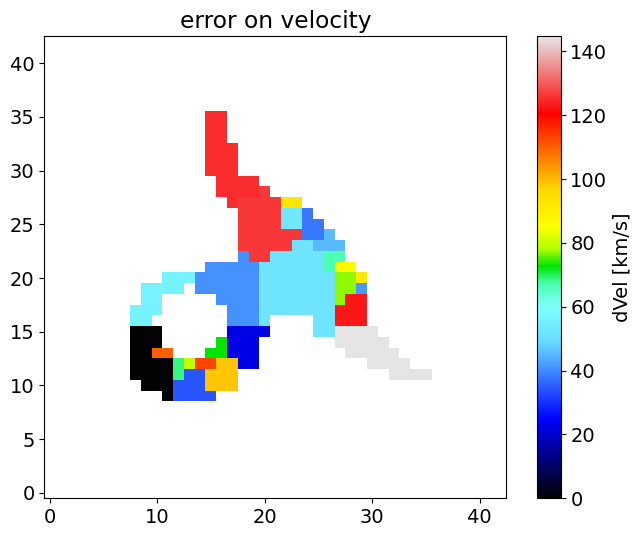

Job's finished!


<Figure size 800x600 with 0 Axes>

In [17]:
psj0147_kinematics.run_slacs_kcwi_kinematics()

In [18]:
def find_nearest(array, value):
    '''
    :param array: wavelength array
    :param value: wavelength that we want to get the index
    :return: the index of the wavelength
    '''
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx


Text(0.5, 0, 'Rest frame Angstroms')

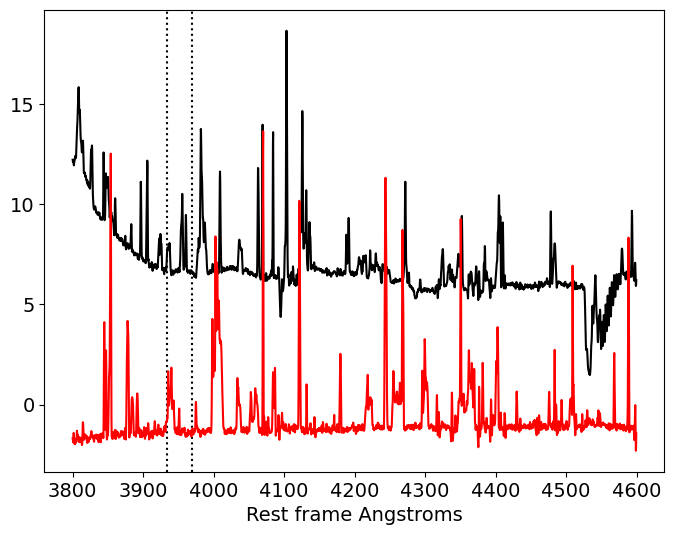

In [45]:
waves = psj0147_kinematics.rest_wave
spectrum = psj0147_kinematics.central_spectrum

wave_lo = 3800
wave_hi = 4600
ind_lo = find_nearest(waves, wave_lo)
ind_hi = find_nearest(waves, wave_hi)

plt.axvline(3934, c='k', linestyle=':')
plt.axvline(3969, c='k', linestyle=':')
plt.plot(waves[ind_lo:ind_hi], spectrum[ind_lo:ind_hi], c='k')
plt.plot(waves[ind_lo:ind_hi], psj0147_kinematics.background_spectrum[ind_lo:ind_hi], c='r')

plt.xlabel('Rest frame Angstroms')

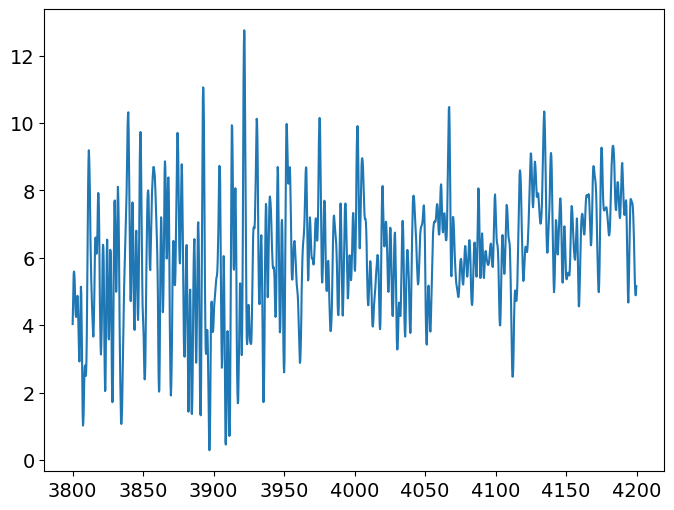

In [20]:
plt.plot(waves[ind_lo:ind_hi], psj0147_kinematics.global_template[ind_lo:ind_hi])

In [89]:
spectrum = fits.getdata('/data/raw_data/Keck_KCWI_drizzle/PSJ0147+4630/KCWI_PSJ0147_extracted_spectrum.fits')
header = fits.getheader('/data/raw_data/Keck_KCWI_drizzle/PSJ0147+4630/KCWI_PSJ0147_extracted_spectrum.fits')
sky = fits.getdata('/data/raw_data/Keck_KCWI_drizzle/PSJ0147+4630/sky_spectrum.fits')
quasar = fits.getdata('/data/raw_data/Keck_KCWI_drizzle/PSJ0147+4630/quasar_spectrum.fits')

In [81]:
cube_header = fits.getheader(kcwi_datacube)

In [82]:
cube_header['WAVGOOD0']

6338.090912621982

In [84]:
h1 = header

In [85]:
header['WAVGOOD0']

6338.090912621982

In [86]:
lam_range = h1['CRVAL1'] + np.array([0., h1['CDELT1']*(h1['NAXIS1'] - 1)])

In [87]:
obs_waves = np.linspace(lam_range[0], lam_range[1], len(sky))

Text(0.5, 0, 'Obs frame Angstroms')

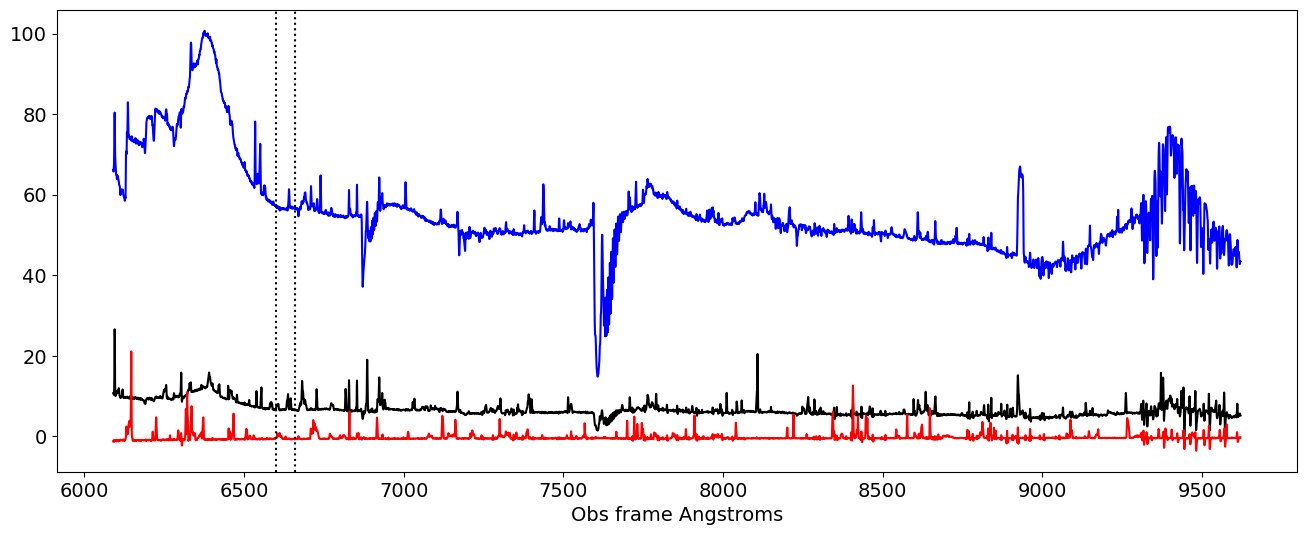

In [90]:
plt.figure(figsize=(16,6))
plt.plot(obs_waves[500:-1000], spectrum[500:-1000], c='k')
plt.plot(obs_waves[500:-1000], sky[500:-1000], c='r')
plt.plot(obs_waves[500:-1000], quasar[500:-1000], c='b')
plt.axvline(6601.252, c='k', linestyle=':')
plt.axvline(6659.982, c='k', linestyle=':')
plt.xlabel('Obs frame Angstroms')